#**Case Study: License Plate Detection**

#**Inference Backend**

#**Data & Libraries Download**

In [53]:
import os
import pdb
import timeit
import platform

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

out = data_download("./reconstruction_utils.zip", "1bU2TuKISOxKXWn6lqZoFmf_peQNL0vw3", OS)
out = data_download("./wpod-net.zip", "19LBRH8__d47nAjLhOFjmCcC-nuGFIKu3", OS)
out = data_download("./TestSet.zip", "15ipXoHP0ENJYUjJbulR7s6z8TLNfe756", OS)

print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  2.480508871999973


#**All General Imports**

In [54]:
import numpy as np
import pandas as pd
import sys
from os.path import splitext
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
from reconstruction_utils import detect_lp
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder

#**All Tensorflow-Keras Imports**

In [55]:
from tensorflow.keras.models import model_from_json

#**All Globals**

In [56]:
rescale = True
summary = True
test_image_path = './TestSet/germany_car_plate.jpg' 
#test_image_path = './TestSet/india_car_plate.jpg' 

#**All Functions Definitions**

In [57]:
# pre-processing input images and pedict with model
def predict_from_model(image, model, labels):

    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    image = image[np.newaxis,:]
    prediction = model.predict(image)
    prediction = [np.argmax(prediction)]
    prediction = labels.inverse_transform(prediction)
    return prediction

def predict_plate(crop_characters, model, labels):

    final_string = ''
    
    for i, character in enumerate(crop_characters):
        title = predict_from_model(character, model, labels)
        title = np.array2string(title)
        final_string += title.strip("'[]")

    return final_string
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts, reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

def plate_segmentation(license_plate, output_path):

    #check if there is at least one license image
    if (len(license_plate)): 
    
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(license_plate[0], alpha=(255.0))

        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

        # visualize results   
        fig = plt.figure(figsize=(12,7))
        plt.rcParams.update({"font.size":18})
        grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
        plot_image = [plate_image, gray, blur, binary,thre_mor]
        plot_name = ["plate_image","gray","blur","binary","dilation"]

        for i in range(len(plot_image)):
            fig.add_subplot(grid[i])
            plt.axis(False)
            plt.title(plot_name[i])
            if i ==0:
                plt.imshow(plot_image[i])
            else:
                plt.imshow(plot_image[i],cmap="gray")

        plt.savefig(output_path + "./segmented_plate.png",dpi=300)
        plt.show(block=False)
        plt.pause(1)

        cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # creat a copy version "test_roi" of plat_image to draw bounding box
        test_roi = plate_image.copy()

        # Initialize a list which will be used to append charater image
        crop_characters = []

        # define standard width and height of character
        digit_w, digit_h = 30, 60

        for c in sort_contours(cont):
            (x, y, w, h) = cv2.boundingRect(c)
            ratio = h/w
            if 1<=ratio<=3.5: # Only select contour with defined ratio
                if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                    # Draw bounding box arroung digit number
                    cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                    # Separate number and gibe prediction
                    curr_num = thre_mor[y:y+h,x:x+w]
                    curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                    _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    crop_characters.append(curr_num)

        print("Detect {} letters...".format(len(crop_characters)))
    
    return crop_characters
    
def load_characters_model(path, characters_recognition_models_path, summary):
    try:
        # Load model architecture, weight and labels
        path = splitext(path)[0]
        
        with open('%s.json' % path, 'r') as json_file:
            loaded_model_json = json_file.read()


        model = model_from_json(loaded_model_json)
        model.load_weights('%s.h5' % path)
        print("[INFO] Character Recognition Model loaded successfully...")


        labels = LabelEncoder()
        labels.classes_ = np.load(characters_recognition_models_path+'lp_labels.npy')
        print("[INFO] Character Recognition Labels loaded successfully...")

        if summary == True:
            model.summary()

        return model, labels
    except Exception as e:
        print(e)


def load_model(path, summary):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")

        if summary == True:
            model.summary()

        return model
    except Exception as e:
        print(e)

def get_plate(vehicle, wpod_net, image_path, Dmax=608, Dmin=256):
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    LpImg = None
    cor = None
    
    try:
        bound_dim = min(side, Dmax)
        _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    except:
        print("No license plate detected.")

    return LpImg, cor

#**Mounting Google Drive via Code**

In [58]:
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Inference Body**

Loading model successfully...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   448         ['input[0][0]']                  
                                16)                                                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, None, None,   64         ['conv2d_1[0][0]']               
 rmalization)                   16)                           

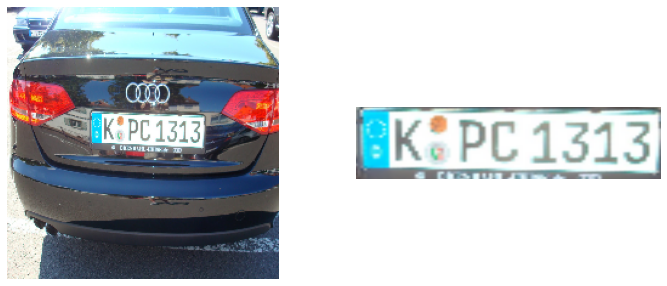

[INFO] Character Recognition Model loaded successfully...
[INFO] Character Recognition Labels loaded successfully...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv

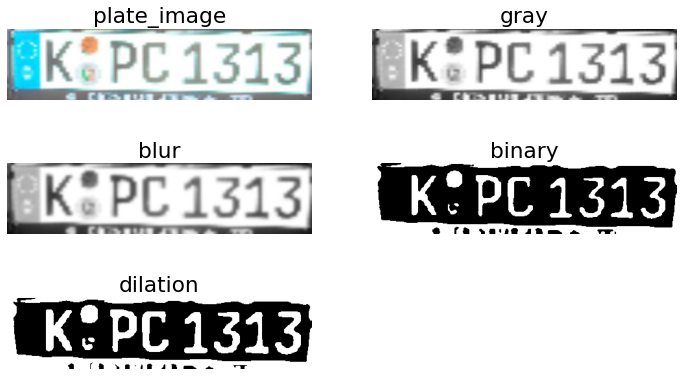

Detect 7 letters...
License Plate Vehicle Number: KPC1313


In [59]:
deepnetwork_pl = load_model("./wpod-net.json", summary)

print ("\nLoading data from the Local Disk...")

img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255
if rescale == True:
    img = cv2.resize(img, (224,224))
    
license_plate, cor = get_plate(img, deepnetwork_pl, test_image_path)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(img)
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(license_plate[0])
plt.savefig("./license_plate.png",dpi=300)
plt.show(block=False)
plt.pause(1)

deepnetwork_ocr, labels = load_characters_model("/content/drive/MyDrive/DL_Models/mobilenet.json", '/content/drive/MyDrive/DL_Models/', summary)

crop_characters = plate_segmentation(license_plate, "./")

vehicle_number = predict_plate(crop_characters, deepnetwork_ocr, labels)

print("License Plate Vehicle Number:", vehicle_number)
